In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [0]:
# distrbucion de probabilidad
def pdf(x,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

# funcion de penalizacion no lineal
def plate(x,delta):
    return max(0,1-np.exp(-(x-delta)))

In [0]:
#terminos en cafe
def Pij(pdf,M,T,mu,sigma):
    I=M.shape[0]
    K=T.shape[1]
    P=np.zeros((I,K))
    b=M@T
    for i in range(I):
        for k in range(K):
            P[i,k]=quad(pdf,0,b[i,k],args=(mu[i],sigma[i]))[0]
    return P

# probabilidad de llegar a tienmpo del nivel J al L
def Pjk(pdf,T,t,M,mu,sigma):
    J=T.shape[0]
    L=M.shape[1]
    P=np.zeros((J,L))
    TM=T@M
    muM=mu@M
    sigmaM=sigma@M
    for j in range(J):
        for l in range(L):
            b=t[0,l]-TM[j,l]
            P[j,l]=quad(pdf,0,b,args=(mu[j,l],sigma[j,l]))[0]
    return P

def clate(t,ts,mu,sigma):
    f = lambda x,delta,mu,sigma:plate(x,delta)*pdf(x,mu,sigma)
    L = t.shape[1]
    c = np.zeros((1,L))
    for i in range(L):
        delta=ts[0,i]-t[0,i]
        if delta<=1:
          c[0,i] = 1
        else:
          c[0,i]=quad(f,delta,np.inf,args=(delta,mu[0,i],sigma[0,i]))[0]
    return c

In [0]:
# T y t son las variables
# todo lo demas es constante

I,J,K,L=4,1,1,1

muij=np.array([1,2.5,4,1.8])
sigmaij=np.array([.2,.1,.5,.4])

mujk=np.array([5.5]).reshape(J,K)
sigmajk=np.array([.9]).reshape(J,K)

mukl=np.array([3]).reshape(K,L)
sigmakl=np.array([.2]).reshape(K,L)

In [0]:
# definicion de constantes
W = (np.array([2,5,3,1.5])*1000).reshape(I,1)
wjl = np.array([3000])
wkl = np.array([1000])

Mkl=np.array([1]).reshape(1,1)
Mij=np.ones((4,1))

ts=np.array([12.2]).reshape(1,1)

tp=np.array([0]).reshape(1,1)
Tp=np.array([0]).reshape(1,1)


Penwjk=np.array([1]).reshape(J,K)
Penwkl=np.array([1]).reshape(1,L)

Pensjk=np.array([1]).reshape(1,J)  
Penskl=np.array([1]).reshape(1,K)

Penmkl=np.array([1]).reshape(1,L)
Penmjk=np.array([1]).reshape(1,L)

In [0]:
# definicion de la funcion de costo
def G(T,t):
  # parte cafe
  g=(Pij(pdf,Mij,T,muij,sigmaij)@Mkl)*(Mij@Pjk(pdf,T,t,Mkl,mujk,sigmajk))*W
  g= np.ones((1,I))@g
  g+=np.ones((1,J))@(Pjk(pdf,T,t,Mkl,mujk,sigmajk)*wjl)
  g+=wkl
  g=(g@(clate(t,ts,mukl,sigmakl).T)).item()

  # parte roja 
  g+=np.sum((np.where((T-Tp)<0,0,T-Tp)*Penwjk))
  g+=(np.where((t-tp)<0,0,t-tp)@Penwkl.T).item()
  return g

def H(T,t):
  #parte azul
  h=Pensjk@(Mij.T)@((np.ones((I,L))-Pij(pdf,Mij,T,muij,sigmaij)@Mkl)*W)
  h=h@(Penmjk.T)
  
  h2=np.ones((1,I))@((Pij(pdf,Mij,T,muij,sigmaij)@Mkl)*
                     (np.ones((I,L))-Mij@Pjk(pdf,T,t,Mkl,mujk,sigmajk))*W)
  h2+=np.ones((1,J))@((np.ones((J,L))-Pjk(pdf,T,t,Mkl,mujk,sigmajk))*wjl)
  h2=h2@((Penskl@Mkl+Penmkl).T)

  h=h+h2
  # parte verde
  # no cuenta porque son constantes jejejej 
  return h[0][0]

In [0]:
# recibe un vector renglon con la matriz aplanada y el vector de forma np.append(T,t)
# delta es la perturbacion para T y t
def k(t,*args):
  T=t[:J*K].reshape(J,K) 
  t=t[-L:].reshape(1,L)
  if (len(args)==0):
    dT=0
    dt=0
  else:
    delta=args[0]
    dT=delta[:J*K].reshape(J,K) 
    dt=delta[-L:].reshape(1,L)
  return G(T+dT,t+dt)+H(T,t)

In [0]:
# metodo de optimizacion basado en gradiente
from scipy.optimize import minimize
t0=np.array([3,8])
tmin=minimize(k,t0,method="BFGS",args=()).x
print(k(tmin))

6837.2347051537745


In [0]:
#Calcula el tv0 inicial y el delta
def delta(Mij,Mkl,muij,sigmaij,mujk,sigmajk,mukl,sigmakl,J,K,L,gamma=5.0):
  A=np.matrix(muij+gamma*sigmaij).T
  B=np.matrix(mujk+gamma*sigmajk)

  deltajk=A*np.ones(J)
  deltajk=np.multiply(Mij,deltajk)
  deltajk=np.where(deltajk<0,0,deltajk)
  deltajk=deltajk.T@np.ones((I,K)) #habia error en las dimensiones del articulo

  deltal=A*np.ones(L)+Mij*B*Mkl
  deltal=np.ones((1,I))@np.where(deltal<0,0,deltal)

  T_init=np.where(deltajk>0,deltajk,Tp)
  T_init=T_init.reshape(1,J*K)
  t_init=np.where(deltal>0,deltal,tp)
  t_init=t_init.reshape(1,L)

  tv0=np.append(T_init,t_init)

  delta=-np.append(np.zeros(J*K),deltal+mukl+gamma*sigmakl-ts.reshape(L))
  return [tv0,delta]

N_iterations=20
pars=delta(Mij,Mkl,muij,sigmaij,mujk,sigmajk,mukl,sigmakl,J,K,L,gamma=5)
tv0=pars[0]
d=pars[1]
best_f=k(tv0)
best_t=tv0

for i in range(N_iterations):
  per=1.0*(N_iterations-i)/N_iterations*d
  opt=minimize(k,tv0,method="BFGS",args=(per))
  tv0=opt.x
  if (best_f>k(tv0)):
    best_f=k(tv0)
    best_t=tv0
  print(k(tv0))

print(best_t)
print(best_f)

15551.997948714874
15546.997020306586
15546.997020306586
15545.996844811449
15540.99810654985
15540.998101528321
15535.996610680975
15535.996610680975
15530.996861312458
15530.996863870012
15525.995859390418
15525.995859397111
15522.997324958606
15522.457350621808
15521.278668933759
15521.278660990862
15521.278660991475
15521.278525289503
15530.824129221324
15922.306262098045
[ 5.88243181 15.29734482]
15521.278525289503


30021.490657961247
7204.897937408736


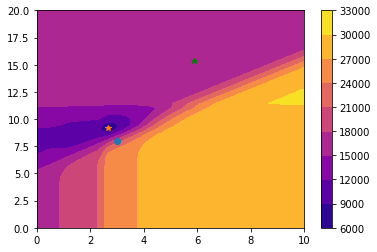

In [0]:
from numpy import ma
from matplotlib import ticker, cm

N = 50
x = np.linspace(0, 10, N)
y = np.linspace(0, 20, N)

X, Y = np.meshgrid(x, y)
z=np.array([k(np.array([x,y])) for x,y in zip(X.flatten(),Y.flatten())]).reshape(X.shape)
maxz=np.max(z)
minz=np.min(z)
print(maxz)
print(minz)
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap="plasma") 
cbar = fig.colorbar(cs)
plt.plot(t0[0],t0[1],"o")
plt.plot(tmin[0],tmin[1],"*")
plt.plot(best_t[0],best_t[1],"*",color="green")
plt.show()

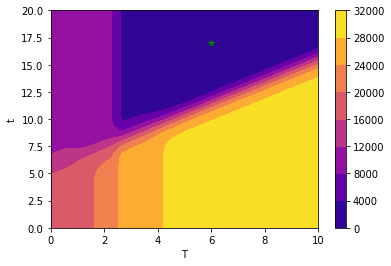

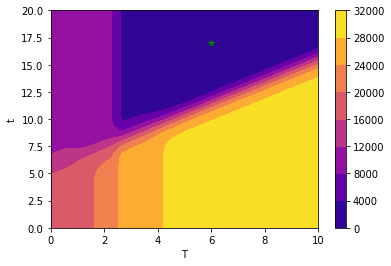

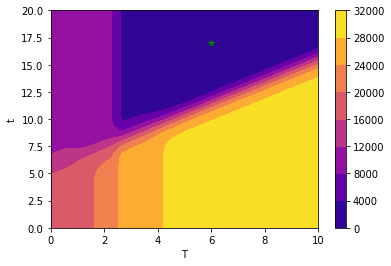

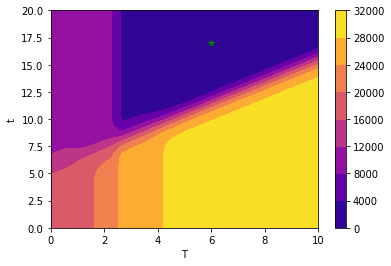

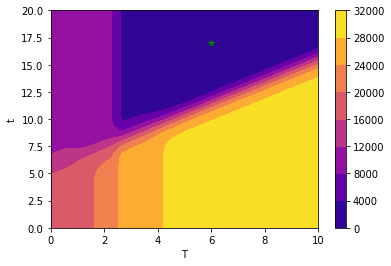

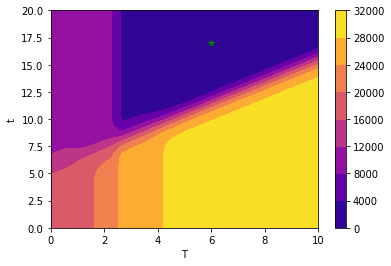

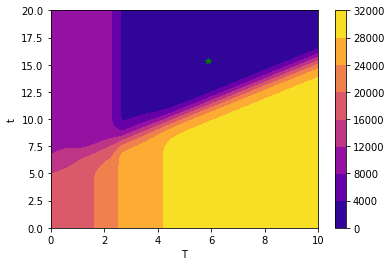

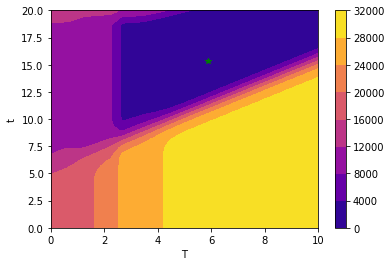

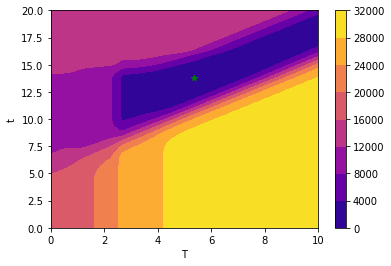

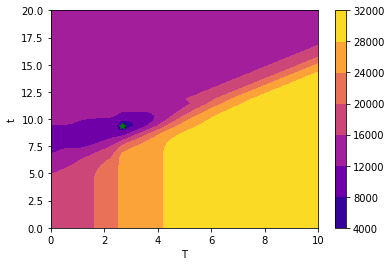

In [0]:
# graficas  y algoritmo homotopico

N_iterations=200
for i in range(N_iterations):
  per=1.0*(N_iterations-i)/N_iterations*d
  opt=minimize(k,tv0,method="BFGS",args=(per))
  tv0=opt.x
  #if (best_f>k(tv0)):
  best_f=k(tv0)
  best_t=tv0
  if (i+1)%20==0:
    fig,ax=plt.subplots()
    z=np.array([k(np.array([x,y]),per) for x,y in zip(X.flatten(),Y.flatten())]).reshape(X.shape)
    cs = ax.contourf(X, Y, z, cmap="plasma") 
    cbar = fig.colorbar(cs)
    plt.plot(best_t[0],best_t[1],"*",color="green")
    ax.set_xlabel('T')
    ax.set_ylabel('t')
    plt.show()

In [0]:
# grafica del estado final 
fig,ax=plt.subplots()
z=np.array([k(np.array([x,y])) for x,y in zip(X.flatten(),Y.flatten())]).reshape(X.shape)
cs = ax.contourf(X, Y, z, cmap="plasma") 
cbar = fig.colorbar(cs)
plt.plot(best_t[0],best_t[1],"*",color="green")
plt.show()

In [0]:
# mejores resultados
print(best_t)
print(best_f)